# FindTheGap

This notebook provides examples for using the _findthegap_ package and its functions for density estimation, finding critical points and estimating 'gappiness' of regions in the data distribution.



Contributors: 
Gabriella Contardo (CCA Simons Foundation), Jason A.S. Hunt (CCA Simons Foundation), David W. Hogg (CCA/NYU/MPIA)


In [1]:
from findthegap.gapper import Gapper

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

from sklearn.preprocessing import StandardScaler

### Data

Data used in this notebook comes from Gaia eDR3 with the following cuts (See code commented below):

Quality cuts:
* bp_rp < 1.5
* phot_g_mean_mag < 14.5
* parallax/parallax_error > 4.
* parallax_error < 0.1
* visibility_periods_used > 5.
* phot_bp_rp_excess_factor < 1.3
* phot_bp_rp_excess_factor > 1.172

Distance cuts (all within 200pc)
* 1./parallax < 0.2
* abs(z) < .2
* abs(phi) < np.arcatan(.2 / 8.178)
* abs(r - r0) < .2

Cuts on velocities:
* abs(vR) < 125
* 100 < vPhi < 300

In [3]:
# # Read the Gaia eDR3 (6D) data file

#from galpy.util import coords
#from astropy.table import Table, hstack

# gaia = Table.read('../data/RV-all-result.fits', format='fits')


# # Parameters to convert from observational to Galactocentric coordinates
# # Distance from Sun to Galactic centre
# ro=8.178
# # Circular velocity at Solar radius
# vo=248.5-12.32
# # Sun's height above the disc plane
# zo=0.0208
# # Sun's motion towards (away from) Galactic centre
# u0=-12.9
# # Sun's peculiar motion in direction of rotation
# v0=12.32
# # Sun's vertical motion away from plane
# w0=8.5



# # Convert to cartesian / Galacocentric
# XYZ= coords.lbd_to_XYZ(gaia['l'],gaia['b'],1.0/gaia['parallax'],degree=True)
# pmllbb= coords.pmrapmdec_to_pmllpmbb(gaia['pmra'],gaia['pmdec'],
#                                           gaia['ra'],gaia['dec'],degree=True,epoch=None)
# vxyz= coords.vrpmllpmbb_to_vxvyvz(gaia['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
#                                        XYZ[:,0],XYZ[:,1],XYZ[:,2],
#                                        XYZ=True,degree=True)
# rpz=coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],ro,zo)
# vcyl=coords.vxvyvz_to_galcencyl(vxyz[:,0],vxyz[:,1],vxyz[:,2],XYZ[:,0]+ro,XYZ[:,1],XYZ[:,2]+zo,[u0, vo+v0, w0],ro,zo)

# # qindx is quality index, roughly what is 'good data'
# qindx=(gaia['bp_rp']<1.5)*(gaia['phot_g_mean_mag']<14.5)*(gaia['parallax']/gaia['parallax_error']>4.)*(gaia['parallax_error']<0.1)*(gaia['visibility_periods_used']>5.)*(gaia['phot_bp_rp_excess_factor']<1.3)*(gaia['phot_bp_rp_excess_factor']>1.172)

# # sindx is Jason's selection index. So, this one is everything < 200 pc from the Sun
# sindx=(1./gaia['parallax']<0.2)


# z_200pc = np.fabs(rpz[:,2])<.2
# phi_200 = np.fabs(rpz[:,1]) < np.arctan(0.2/8.178)
# r_200 = (np.fabs(rpz[:,0]-ro)<0.2)

# vrmask = np.fabs(vcyl[:,0]) < 125
# vphimask = (vcyl[:,1] <300) & (vcyl[:,1]>100)
# all_mask = qindx*sindx*z_200pc*phi_200*r_200*vrmask*vphimask



In [4]:
data_nonorm = np.load('../data/data_MW_cut.npy')

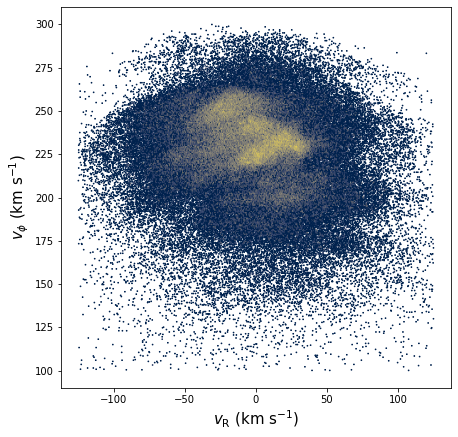

In [5]:

plt.figure(figsize=(7,7))
plt.hexbin(data_nonorm[:,0],data_nonorm[:,1],
           gridsize=500,bins='log',mincnt=1,cmap=cm.cividis) 

plt.xlabel(r'$v_{\mathrm{R}}\ (\mathrm{km\ s}^{-1})$',fontsize=15)
plt.ylabel(r'$v_{\phi}\ (\mathrm{km\ s}^{-1})$',fontsize=15)
plt.show()

### Normalize data


In [6]:
scaler = StandardScaler()
scaler.fit(data_nonorm)
data = scaler.transform(data_nonorm)

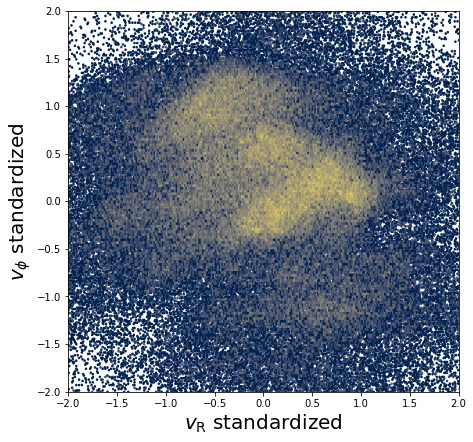

In [7]:
fontsize = 20 
xlims_norm, ylims_norm = (-2.,2.), (-2.,2.)

plt.figure(figsize=(7,7))
plt.hexbin(data[:,0],data[:,1],
           gridsize=500,bins='log',mincnt=1,cmap=cm.cividis) 


plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)
plt.show()

In [8]:
# Boundaries for the Gapper (if none are provided, this is the default mode)
bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])


## Create a Gapper

In [9]:

bw = .15 
gridding_size = 80
gapper_base = Gapper(data, bw, bounds)

### Compute the density estimate on a grid over the dataspace

In [10]:
t = time.time()
grid_data, grid_density = gapper_base.compute_density_grid(gridding_size = gridding_size)
print((time.time() - t))

## Todo clean this

5.1454174518585205


In [11]:
density_matr = grid_density.reshape((gridding_size, gridding_size))

In [12]:
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size) for d in range(data.shape[1]) ]
meshgrid = np.array(np.meshgrid(*grid_linspace, indexing='ij'))

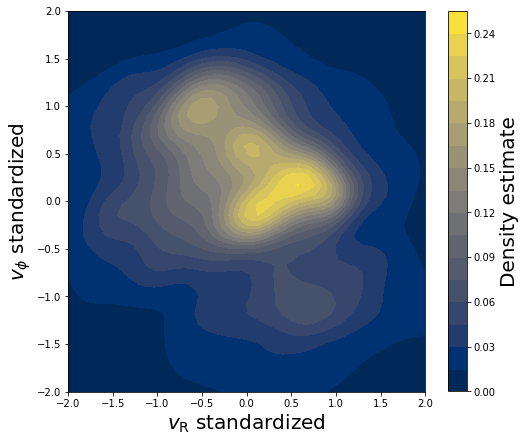

In [13]:


plt.figure(figsize=(8,7))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)
cb = plt.colorbar(label='Density estimate')

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)


plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()

### Compute estimation of all critical points

In [14]:
t = time.time()
critical_points = gapper_base.compute_all_critical_points()
print(time.time() - t)

List of grid points for critical points: (2585, 2)
finished optimizations
2415 2415
60.00649571418762


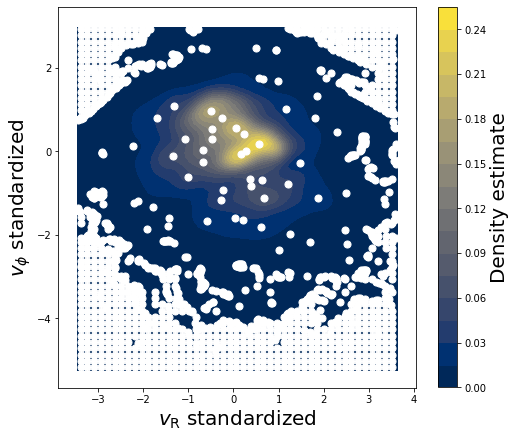

In [15]:
fontsize = 20 

plt.figure(figsize=(8,7))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)
cb = plt.colorbar(label='Density estimate')

# plt.xlim(*xlims_norm)
# plt.ylim(*ylims_norm)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)

plt.scatter(critical_points[:,0], critical_points[:,1], s=50, c='w', label='Critical points')

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()

### Get statistics for a point / location in the space:

In [16]:
point_ = np.array([ [0.5, -0.5], [1.,0.]])

## This returns a torch.tensor
density_ofpt = gapper_base.get_density(point_)
print(density_ofpt)

tensor([0.0660, 0.1509], grad_fn=<MulBackward0>)


In [17]:
## Following function gets the density estimate, its gradient, and the eigenvalues and eigenvector of the Hessian
## of a single point

point_ = np.array([0.5, -0.5])

eig_val_H, eig_vec_H, dens_est, gradient, Hessian = gapper_base.get_g_H_eigvH(point_)
print(dens_est)
print(gradient)
print(eig_val_H)
print(eig_vec_H)
print(Hessian)

[0.06596285]
[-0.02803764  0.09905706]
[0.9963381  0.02103232]
[[-0.2818219  -0.95946676]
 [ 0.95946676 -0.2818219 ]]
[[ 0.0984946  -0.26372144]
 [-0.26372147  0.9188758 ]]


In [18]:
## Other function can get those .... 

In [19]:
## Some functions are available if one wants to compute only the gradient of the density estimate of a point:
grad_pt = gapper_base.get_grad_density(point_)

## Or the Hessian:
hessian_pt = gapper_base.get_Hessian(point_)

## But if one wants to get density + gradient + Hessian, the 'get_grad_density' function might not be ideal because
## of redundant calling of the density estimate. Previously computed density estimate can be passed as input
## of get_grad_density.

## Otherwise, one can also simply access the density estimator (QuarticKDE object) through the gapper_base.kde object
## gapper_base.kde.score_sample function  and rely on torch autograd functions (torch.autograd.gradient,
## torch.autograd.functional.hessian)

print(grad_pt)
print(hessian_pt)

(tensor([-0.0280,  0.0991]),)
[[ 0.0984946  -0.26372144]
 [-0.26372147  0.9188758 ]]


## Compute information for critical points
 

Eigen-values of the Hessian tell interesting things about the nature of a critical point
Its index tells us if it is a minima, maxima or a saddle:

index = number of negative eigenvalues of the Hessian of the density estimate (the eigenvalues of the Hessian give us indications on the direction of the curvature of the density field). 

Maximum point: index of d (number of dimensions of data space)

Minimum point: index of 0

Saddle point : 0 < index < d



Looking at the maximum eigenvalue of the Hessian is also a good indicator to find the best 'gap' point of interest


In [20]:
H_eigval_crits = []
t = time.time()
for pts in critical_points:
    eig_val_H, eig_vec_H, logd_apoint, g, H = gapper_base.get_g_H_eigvH(pts)
    H_eigval_crits.append(eig_val_H)

print(time.time() - t)

4.024929046630859


In [21]:
H_eigval_crits = np.array(H_eigval_crits)

max_eigval_H = np.max(H_eigval_crits, axis=1)

In [22]:
index_count_eigvalH = np.sum(H_eigval_crits < 0 , axis=1) 

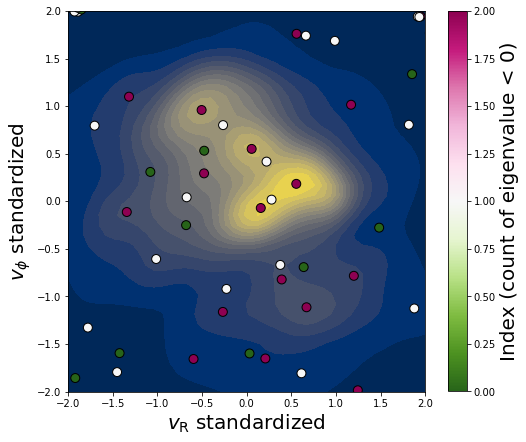

In [23]:

plt.figure(figsize=(8,7))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)

critsc = plt.scatter(critical_points[:,0], critical_points[:,1], s=80, c=index_count_eigvalH,
            cmap = cm.PiYG.reversed(), edgecolor='k', vmin =0, 
                     vmax=2)

cb = plt.colorbar(label='Index (count of eigenvalue < 0)')


ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)


plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()

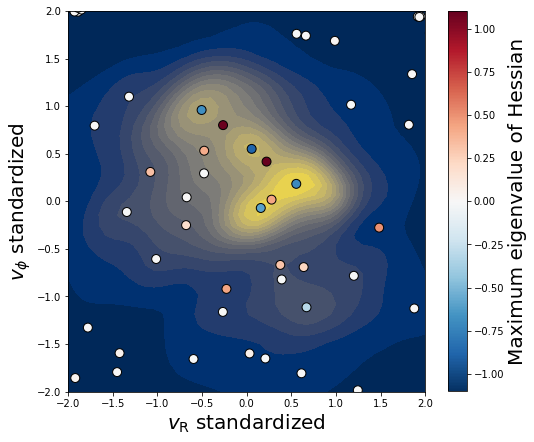

In [24]:
## Critical points with a maximum eigenvalue of the Hessian close to zero are of less interest if one is looking 
## gaps or bumps in the density distribution


plt.figure(figsize=(8,7))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)

critsc = plt.scatter(critical_points[:,0], critical_points[:,1], s=80, c=max_eigval_H,
            cmap = cm.RdBu.reversed(), edgecolor='k', vmin = -(np.max(np.abs(max_eigval_H))), 
                     vmax=np.max(np.abs(max_eigval_H)))

cb = plt.colorbar(label='Maximum eigenvalue of Hessian')

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()

### Difference between index and maximum eigenvalue of H

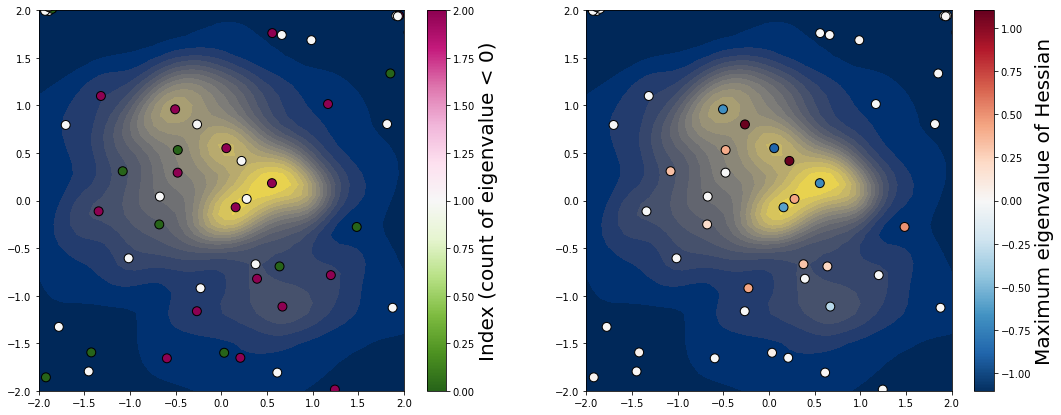

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(9*2,7))


ctf = axs[0].contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)

critsc = axs[0].scatter(critical_points[:,0], critical_points[:,1], s=80, c= index_count_eigvalH,
                        cmap = cm.PiYG.reversed(), edgecolor='k', vmin =0, 
                     vmax=2)

cb= fig.colorbar(critsc, ax=axs[0], label='Index (count of eigenvalue < 0)')
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)

ctf = axs[1].contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)

critsc = axs[1].scatter(critical_points[:,0], critical_points[:,1], s=80, c=max_eigval_H,
            cmap = cm.RdBu.reversed(), edgecolor='k', vmin = -(np.max(np.abs(max_eigval_H))), 
                     vmax=np.max(np.abs(max_eigval_H)))


cb = fig.colorbar(critsc, ax=axs[1], label='Maximum eigenvalue of Hessian')
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)

for i in [0,1]:
    axs[i].set_xlim(*xlims_norm)
    axs[i].set_ylim(*ylims_norm)


plt.show()

## Computing 'gradient' path from critical points of interest

Let's look at the critical points with the largest maximum eigenvalue for the Hessian (the critical points corresponding to 'gappiest' regions)

In [26]:
N = 15

idx_best_crits  = np.argsort(max_eigval_H)[::-1][:N]

In [27]:
paths_best_crits = []
t = time.time()
for crit in critical_points[idx_best_crits]:
    path, feedbacks = gapper_base.compute_path_of_a_critpt(crit)
    paths_best_crits.append(path)

print(time.time() - t)

6.489766359329224


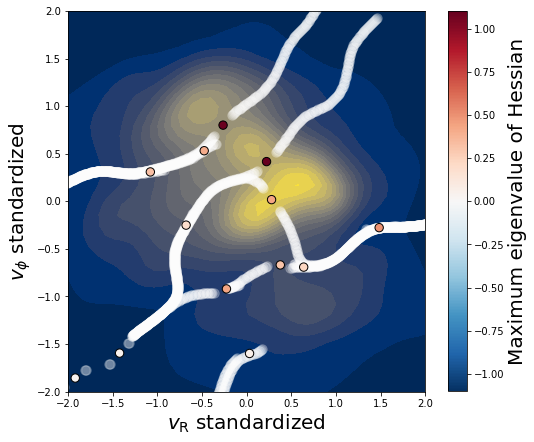

In [28]:

plt.figure(figsize=(8,7))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)

for path in paths_best_crits:
    plt.scatter(path[:,0], path[:,1], s=90, c='w', alpha=.25)

    
critsc = plt.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
                     s=70, c=max_eigval_H[idx_best_crits],
            cmap = cm.RdBu.reversed(), edgecolor='k', vmin = -(np.max(np.abs(max_eigval_H))), 
                     vmax=np.max(np.abs(max_eigval_H)))

cb = plt.colorbar(label='Maximum eigenvalue of Hessian')


plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()

We can see that the paths connect critical points with each other / overlap

In [29]:
t = time.time()

eig_vals_H = np.array([np.linalg.eigh(gapper_base.get_Hessian(pt))[0] for pt in grid_data])

print(time.time() -t)

17.627131462097168


In [30]:
max_eig_vals_H_grid = np.max(eig_vals_H, axis=1).reshape((gridding_size, gridding_size))

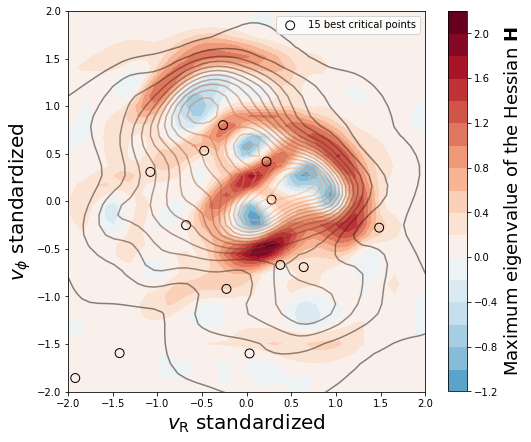

In [31]:
plt.figure(figsize=(8,7))

plt.contourf(meshgrid[0], meshgrid[1], max_eig_vals_H_grid, 20, cmap=cm.RdBu.reversed(),
             vmin = -(np.max(np.abs(max_eig_vals_H_grid))), vmax=np.max(np.abs(max_eig_vals_H_grid)))

cb = plt.colorbar(label="Maximum eigenvalue of the Hessian $\mathbf{H}$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.copper, alpha=.5)


critsc = plt.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
                     s=80, c="None", edgecolor='k', label='{} best critical points'.format(N))

plt.legend()

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)


plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.show()


## Computing PiHPi (projection of the Hessian into the orthogonal subspace of the density gradient) matrix

In [32]:
t = time.time()

## If the gradient and Hessian have been computed before, they can be put as argument of that function to avoid
## recomputing them

PiHPis_grid = []
eigval_PiHPi = [] 

for pt in grid_data:
    _pihpi = gapper_base.get_PiHPi(pt) 
    _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)
    
    PiHPis_grid.append(_pihpi)
    eigval_PiHPi.append(_pihpi_eigval)

print(time.time() -t)

25.43270516395569


## Maximum eigenvalue of PiHPi as gap-criterion

In [33]:
PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)

In [34]:
max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)

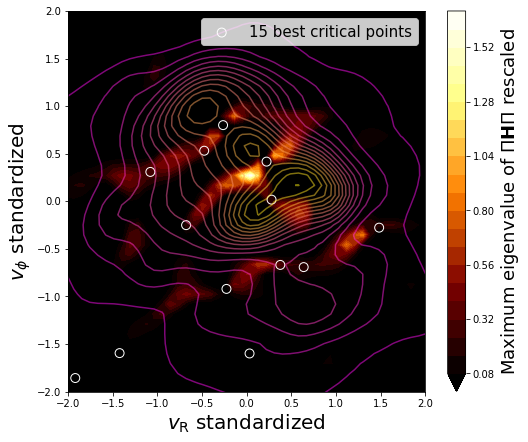

In [35]:
max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size, gridding_size))

plt.figure(figsize=(8,7))

pi = plt.contourf(meshgrid[0], meshgrid[1], max_eigval_PiHPi_resh, 20, cmap=cm.afmhot, extend='min')
plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)

critsc = plt.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
                     s=80, c="None", edgecolor='w', label='{} best critical points'.format(N))


cb = plt.colorbar(pi, label="Maximum eigenvalue of $\Pi \mathbf{H} \Pi$ rescaled")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

plt.show()

## Looking at the Trace of PiHPi

In [36]:
trace_PiHPi = np.trace(PiHPis_grid, axis1=1, axis2=2)

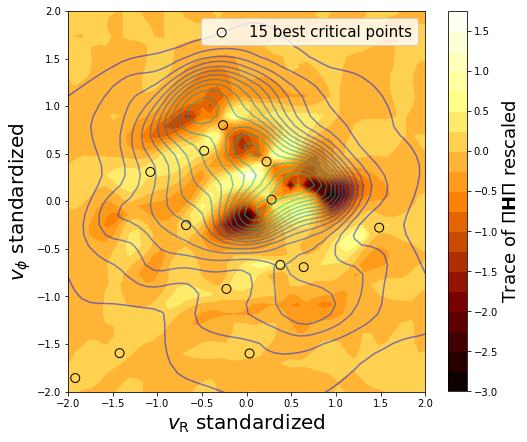

In [37]:
trace_PiHPi_resh = trace_PiHPi.reshape((gridding_size, gridding_size))

plt.figure(figsize=(8,7))

pi = plt.contourf(meshgrid[0], meshgrid[1], trace_PiHPi_resh, 20, cmap=cm.afmhot)
plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.winter, alpha=.5)

critsc = plt.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
                     s=80, c="None", edgecolor='k', label='{} best critical points'.format(N))


cb = plt.colorbar(pi, label="Trace of $\Pi \mathbf{H} \Pi$ rescaled")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

plt.show()

## Similarly, these measures can be computed directly for points within the dataset:

(might take a bit given the number of examples in the dataset but could be optimized / parallelized)

In [ ]:
t = time.time()

PiHPis_data = []
eigval_PiHPi_data = [] 

for pt in data:
    _pihpi = gapper_base.get_PiHPi(pt) 
    _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)
    
    PiHPis_data.append(_pihpi)
    eigval_PiHPi_data.append(_pihpi_eigval)
    
    
print(time.time() -t)

### One can then select the points of interest using some threshold on one of the statistics (e.g. above some threshold)


In [ ]:
max_eigval_PiHPi_data = np.max(eigval_PiHPi_data, axis=1)

In [ ]:
threshold_eigvalPiHPi = np.percentile(eigval_PiHPi, 99)

In [ ]:
plt.figure(figsize=(7,7))

mask_threshold_eigval = max_eigval_PiHPi_data > threshold_eigvalPiHPi


plt.scatter(data[mask_threshold_eigval][:,0], data[mask_threshold_eigval][:,1], 
                     s=1, c="k")


plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.winter, alpha=.5)


plt.title("Points selected with threshold cut using max eigenvalue on grid")
plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)

plt.show()

In [ ]:

plt.figure(figsize=(7,7))
plt.hexbin(data[:,0],data[:,1],
           gridsize=500,bins='log',mincnt=1,cmap=cm.cividis) 


mask_threshold_eigval = max_eigval_PiHPi_data > threshold_eigvalPiHPi


plt.scatter(data[mask_threshold_eigval][:,0], data[mask_threshold_eigval][:,1], 
                     s=.5, c="r", alpha=.1)



plt.xlabel(r'$v_{\mathrm{R}}$ standardized',fontsize=fontsize)
plt.ylabel(r'$v_{\phi}$ standardized',fontsize=fontsize)

plt.xlim(*xlims_norm)
plt.ylim(*ylims_norm)
plt.show()